### Bibliotecas

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import shap # Adicionado para interpretabilidade
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from flaml import AutoML
from keras.src.utils import to_categorical
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, auc
from sklearn.feature_selection import SelectFromModel
import keras_tuner as kt

D:\Projetos\UFABC\UFABC_SI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Carregando Dados

In [49]:
df_benign = pd.read_csv(r'D:\Projetos\UFABC\UFABC_SI\Dados\Benign Traffic.csv')

In [50]:
df_mqtt_ddos_publish = pd.read_csv(r'D:\Projetos\UFABC\UFABC_SI\Dados\MQTT DDoS Publish Flood.csv')

In [51]:
df_mqtt_dos_connect = pd.read_csv(r'D:\Projetos\UFABC\UFABC_SI\Dados\MQTT DoS Connect Flood.csv')

In [52]:
df_mqtt_dos_publish = pd.read_csv(r'D:\Projetos\UFABC\UFABC_SI\Dados\MQTT DoS Publish Flood.csv')

In [53]:
df_mqtt_malformed = pd.read_csv(r'D:\Projetos\UFABC\UFABC_SI\Dados\MQTT Malformed.csv')

### Criando classiicação


In [54]:
df_benign['Target'] = 'Benign'
df_mqtt_ddos_publish['Target'] = 'DDoS Publish Flood'
df_mqtt_dos_connect['Target'] = 'DoS Connect Flood'
df_mqtt_dos_publish['Target'] = 'DoS Publish Flood'
df_mqtt_malformed['Target'] = 'Malformed'

#### Junção DFS


In [55]:
df_fail = pd.concat([
    df_benign,
    df_mqtt_ddos_publish,
    df_mqtt_dos_connect,
    df_mqtt_dos_publish,
    df_mqtt_malformed
], ignore_index=True)

### Conversão para datetime

In [56]:
df_fail['Timestamp_data'] = df_fail['Timestamp'].astype(str).str.split(expand=True)[0]
df_fail['Timestamp_hora'] = df_fail['Timestamp'].astype(str).str.split(expand=True)[1]

### Exploração dos dados

In [57]:
df_fail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687763 entries, 0 to 687762
Data columns (total 88 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Flow ID                     687763 non-null  object 
 1   Src IP                      687763 non-null  object 
 2   Src Port                    687763 non-null  int64  
 3   Dst IP                      687763 non-null  object 
 4   Dst Port                    687763 non-null  int64  
 5   Protocol                    687763 non-null  int64  
 6   Timestamp                   687763 non-null  object 
 7   Flow Duration               687763 non-null  int64  
 8   Total Fwd Packet            687763 non-null  int64  
 9   Total Bwd packets           687763 non-null  int64  
 10  Total Length of Fwd Packet  687763 non-null  float64
 11  Total Length of Bwd Packet  687763 non-null  float64
 12  Fwd Packet Length Max       687763 non-null  float64
 13  Fwd Packet Len

In [58]:
df_fail.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,687763.000000,687763.000000,687763.0,6.877630e+05,687763.000000,687763.000000,6.877630e+05,6.877630e+05,687763.000000,687763.000000,...,687763.000000,6.877630e+05,6.877630e+05,6.877630e+05,6.877630e+05,6.877630e+05,6.877630e+05,6.877630e+05,6.877630e+05,687763.000000
mean,20762.749321,28151.500581,6.0,5.759365e+06,10.242072,8.023024,2.608665e+03,1.586545e+03,83.222386,20.848221,...,24.124235,5.096964e+04,4.300750e+04,1.297291e+05,1.376203e+04,1.645320e+06,2.799889e+04,1.669391e+06,1.614595e+06,0.952571
std,22650.778716,23347.899582,0.0,2.236155e+07,164.515424,133.175122,9.901705e+04,2.541857e+04,318.506059,138.418076,...,5.791820,5.501210e+05,5.379696e+05,1.565035e+06,2.685590e+05,8.751461e+06,6.782813e+05,8.833452e+06,8.693729e+06,0.212555
min,80.000000,80.000000,6.0,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,1883.000000,1883.000000,6.0,8.210000e+02,2.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
50%,1883.000000,36576.000000,6.0,4.855900e+04,2.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
75%,43528.000000,49444.000000,6.0,9.985430e+05,5.000000,3.000000,1.700000e+01,4.000000e+00,17.000000,0.000000,...,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
max,65278.000000,65487.000000,6.0,1.200000e+08,31872.000000,6325.000000,4.614014e+07,6.902088e+06,1460.000000,1448.000000,...,52.000000,1.007220e+08,2.087959e+07,1.007220e+08,1.007220e+08,1.199793e+08,7.496464e+07,1.199793e+08,1.199793e+08,1.000000


In [59]:
df_fail['Attack Name'].unique()

array(['Benign Traffic', 'MQTT DDoS Publish Flood',
       'MQTT DoS Connect Flood', 'MQTT DoS Publish Flood',
       'MQTT Malformed'], dtype=object)

In [60]:
df_fail.corr(numeric_only=True)

,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
Src Port,1.000000,-0.934979,NaN,0.164342,0.043925,0.037011,0.030067,-0.049283,0.276261,0.173093,...,0.610480,0.064675,0.057431,0.058793,0.033223,0.073132,0.011618,0.073344,0.072222,-0.150405
Dst Port,-0.934979,1.000000,NaN,-0.204995,-0.039325,-0.032947,-0.026333,0.048986,-0.259874,-0.167184,...,-0.608004,-0.094638,-0.087487,-0.088607,-0.041660,-0.096542,-0.016382,-0.096867,-0.095333,0.186068
Protocol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Flow Duration,0.164342,-0.204995,NaN,1.000000,0.174497,0.190097,0.079538,0.029090,0.009494,-0.023563,...,0.303802,0.421841,0.392586,0.397026,0.183183,0.604476,0.171085,0.610351,0.593303,-0.879850
Total Fwd Packet,0.043925,-0.039325,NaN,0.174497,1.000000,0.934896,0.773991,0.221780,0.126217,0.002156,...,0.058816,0.022500,0.007248,0.012918,0.033207,-0.004106,-0.000472,-0.004090,-0.004097,-0.032582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Idle Mean,0.073132,-0.096542,NaN,0.604476,-0.004106,-0.004263,-0.003032,-0.011047,-0.010648,-0.014406,...,0.220918,0.133920,0.071790,0.079388,0.159585,1.000000,0.122896,0.998146,0.997810,-0.553145
Idle Std,0.011618,-0.016382,NaN,0.171085,-0.000472,-0.000023,-0.000879,-0.002316,0.001220,-0.002559,...,0.028307,0.060299,0.049428,0.041968,0.048090,0.122896,1.000000,0.180930,0.060444,-0.128951
Idle Max,0.073344,-0.096867,NaN,0.610351,-0.004090,-0.004205,-0.003058,-0.011094,-0.010394,-0.014446,...,0.220148,0.137443,0.075580,0.082346,0.161085,0.998146,0.180930,1.000000,0.992190,-0.557136
Idle Min,0.072222,-0.095333,NaN,0.593303,-0.004097,-0.004312,-0.002975,-0.010923,-0.010888,-0.014346,...,0.220145,0.128814,0.067561,0.075796,0.155635,0.997810,0.060444,0.992190,1.000000,-0.544281


<Axes: >

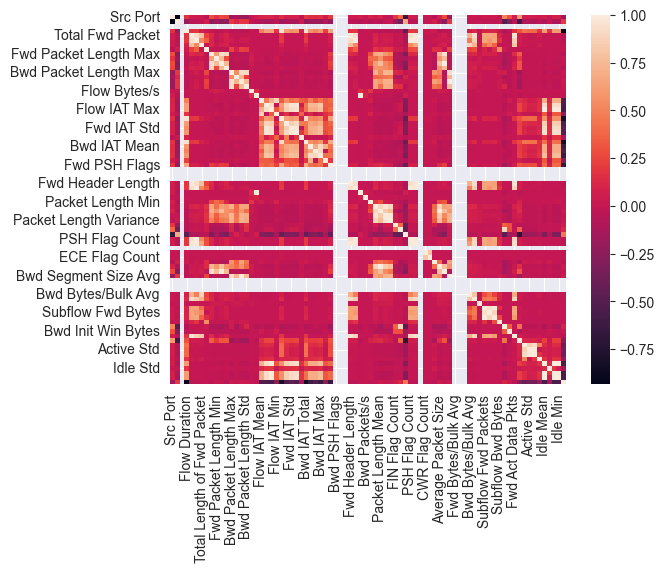

In [61]:
sns.heatmap(df_fail.corr(numeric_only=True))

### Engenharia de Features

### 1. Features de Janela Deslizante (Rolling Window)

In [62]:
# Vamos criar features que representam a média, desvio padrão, mínimo e máximo dos sensores em diferentes janelas de tempo (5, 15 e 30 períodos).

# Garante que os dados estão ordenados por equipamento e tempo
df_feat = df_fail.sort_values(by=['Flow ID', 'Timestamp']).copy()

In [63]:
# Célula para inserir após o sort_values
# Lista de colunas numéricas para aplicar as features
features_to_engineer = [
    'Flow Duration',
    'Total Fwd Packet',
    'Total Bwd packets',
    'Total Length of Fwd Packet',
    'Total Length of Bwd Packet',
    'Fwd Packet Length Max',
    'Fwd Packet Length Min',
    'Fwd Packet Length Mean',
    'Fwd Packet Length Std',
    'Bwd Packet Length Max',
    'Bwd Packet Length Min',
    'Bwd Packet Length Mean',
    'Bwd Packet Length Std',
    'Flow IAT Mean',
    'Flow IAT Std',
    'Flow IAT Max',
    'Flow IAT Min',
    'Fwd IAT Total',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Fwd IAT Max',
    'Fwd IAT Min'
]

In [64]:
# Célula para inserir após o sort_values
# Lista de colunas numéricas para aplicar as features
#Foi comentado pois usava todas as colunas numericas

#numeric_cols = df_feat.select_dtypes(include=np.number).columns.tolist()

In [65]:
# Janelas de tempo a serem usadas
window_sizes = [5, 10, 20]

In [66]:
for feature in features_to_engineer:
    for window in window_sizes:
        # Agrupa por ID e aplica a janela deslizante
        rolling_mean = df_feat.groupby('Flow ID')[feature].rolling(window=window, min_periods=1).mean().reset_index(
            drop=True)
        rolling_std = df_feat.groupby('Flow ID')[feature].rolling(window=window, min_periods=1).std().reset_index(drop=True)
        rolling_max = df_feat.groupby('Flow ID')[feature].rolling(window=window, min_periods=1).max().reset_index(drop=True)

        df_feat[f'{feature}_mean_{window}'] = rolling_mean
        df_feat[f'{feature}_std_{window}'] = rolling_std
        df_feat[f'{feature}_max_{window}'] = rolling_max

print("Features de janela deslizante criadas.")

C:\Users\alexa\AppData\Local\Temp\ipykernel_61728\602338582.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[f'{feature}_std_{window}'] = rolling_std
C:\Users\alexa\AppData\Local\Temp\ipykernel_61728\602338582.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[f'{feature}_max_{window}'] = rolling_max
C:\Users\alexa\AppData\Local\Temp\ipykernel_61728\602338582.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

Features de janela deslizante criadas.


C:\Users\alexa\AppData\Local\Temp\ipykernel_61728\602338582.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[f'{feature}_mean_{window}'] = rolling_mean
C:\Users\alexa\AppData\Local\Temp\ipykernel_61728\602338582.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[f'{feature}_std_{window}'] = rolling_std
C:\Users\alexa\AppData\Local\Temp\ipykernel_61728\602338582.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

### 2. Features de Atraso (Lag Features)

In [67]:
# Criaremos colunas com os valores dos sensores de 1, 2 e 3 períodos atrás.

lags = [1, 2, 3]

for feature in features_to_engineer:
    for lag in lags:
        # Agrupa por ID e aplica o shift
        df_feat[f'{feature}_lag_{lag}'] = df_feat.groupby('Flow ID')[feature].shift(lag)

print("Features de atraso criadas.")

C:\Users\alexa\AppData\Local\Temp\ipykernel_61728\4156080529.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[f'{feature}_lag_{lag}'] = df_feat.groupby('Flow ID')[feature].shift(lag)
C:\Users\alexa\AppData\Local\Temp\ipykernel_61728\4156080529.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[f'{feature}_lag_{lag}'] = df_feat.groupby('Flow ID')[feature].shift(lag)
C:\Users\alexa\AppData\Local\Temp\ipykernel_61728\4156080529.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

Features de atraso criadas.


C:\Users\alexa\AppData\Local\Temp\ipykernel_61728\4156080529.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[f'{feature}_lag_{lag}'] = df_feat.groupby('Flow ID')[feature].shift(lag)
C:\Users\alexa\AppData\Local\Temp\ipykernel_61728\4156080529.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[f'{feature}_lag_{lag}'] = df_feat.groupby('Flow ID')[feature].shift(lag)
C:\Users\alexa\AppData\Local\Temp\ipykernel_61728\4156080529.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

### 3. Limpeza Final do DataFrame de Features

In [68]:
# A criação de janelas e lags gera valores NaN no início de cada série temporal (por equipamento).
# Vamos remover essas linhas para garantir que o modelo só treine com dados completos.

print(f"Tamanho do DataFrame antes da limpeza de NaN: {df_feat.shape}")

# Remove todas as linhas que contenham qualquer valor NaN gerado
df_feat.dropna(inplace=True)

print(f"Tamanho do DataFrame após a limpeza: {df_feat.shape}")

# Visualizando o resultado final com as novas features
df_feat.head()

Tamanho do DataFrame antes da limpeza de NaN: (687763, 352)
Tamanho do DataFrame após a limpeza: (397104, 352)


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Fwd IAT Mean_lag_3,Fwd IAT Std_lag_1,Fwd IAT Std_lag_2,Fwd IAT Std_lag_3,Fwd IAT Max_lag_1,Fwd IAT Max_lag_2,Fwd IAT Max_lag_3,Fwd IAT Min_lag_1,Fwd IAT Min_lag_2,Fwd IAT Min_lag_3
7795,10.0.0.1-10.0.0.254-33515-1883-6,10.0.0.1,33515,10.0.0.254,1883,6,13/09/2023 01:06:59 PM,119003221,8,8,...,1.499995e+07,1.559893e+07,1.551079e+07,1.551093e+07,30000093.0,30002226.0,30000942.0,1331.0,1313.0,2137.0
7848,10.0.0.1-10.0.0.254-33515-1883-6,10.0.0.1,33515,10.0.0.254,1883,6,13/09/2023 01:08:59 PM,119003854,8,8,...,1.499999e+07,1.559807e+07,1.559893e+07,1.551079e+07,30001685.0,30000093.0,30002226.0,2535.0,1331.0,1313.0
7891,10.0.0.1-10.0.0.254-33515-1883-6,10.0.0.1,33515,10.0.0.254,1883,6,13/09/2023 01:10:59 PM,119998157,9,8,...,1.700045e+07,1.559851e+07,1.559807e+07,1.559893e+07,29997430.0,30001685.0,30000093.0,1404.0,2535.0,1331.0
7966,10.0.0.1-10.0.0.254-33515-1883-6,10.0.0.1,33515,10.0.0.254,1883,6,13/09/2023 01:13:00 PM,119962351,9,7,...,1.700046e+07,1.551037e+07,1.559851e+07,1.559807e+07,29998676.0,29997430.0,30001685.0,1379.0,1404.0,2535.0
8036,10.0.0.1-10.0.0.254-33515-1883-6,10.0.0.1,33515,10.0.0.254,1883,6,13/09/2023 01:15:00 PM,119999876,9,8,...,1.700055e+07,1.550502e+07,1.551037e+07,1.559851e+07,30000824.0,29998676.0,29997430.0,2113.0,1379.0,1404.0


In [69]:
# A criação de janelas e lags gera valores NaN no início de cada série temporal (por equipamento).
# Vamos remover essas linhas para garantir que o modelo só treine com dados completos.

print(f"Tamanho do DataFrame antes da limpeza de NaN: {df_feat.shape}")

# Remove todas as linhas que contenham qualquer valor NaN gerado
df_feat.dropna(inplace=True)

print(f"Tamanho do DataFrame após a limpeza: {df_feat.shape}")

# Visualizando o resultado final com as novas features
df_feat.head()

Tamanho do DataFrame antes da limpeza de NaN: (397104, 352)
Tamanho do DataFrame após a limpeza: (397104, 352)


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Fwd IAT Mean_lag_3,Fwd IAT Std_lag_1,Fwd IAT Std_lag_2,Fwd IAT Std_lag_3,Fwd IAT Max_lag_1,Fwd IAT Max_lag_2,Fwd IAT Max_lag_3,Fwd IAT Min_lag_1,Fwd IAT Min_lag_2,Fwd IAT Min_lag_3
7795,10.0.0.1-10.0.0.254-33515-1883-6,10.0.0.1,33515,10.0.0.254,1883,6,13/09/2023 01:06:59 PM,119003221,8,8,...,1.499995e+07,1.559893e+07,1.551079e+07,1.551093e+07,30000093.0,30002226.0,30000942.0,1331.0,1313.0,2137.0
7848,10.0.0.1-10.0.0.254-33515-1883-6,10.0.0.1,33515,10.0.0.254,1883,6,13/09/2023 01:08:59 PM,119003854,8,8,...,1.499999e+07,1.559807e+07,1.559893e+07,1.551079e+07,30001685.0,30000093.0,30002226.0,2535.0,1331.0,1313.0
7891,10.0.0.1-10.0.0.254-33515-1883-6,10.0.0.1,33515,10.0.0.254,1883,6,13/09/2023 01:10:59 PM,119998157,9,8,...,1.700045e+07,1.559851e+07,1.559807e+07,1.559893e+07,29997430.0,30001685.0,30000093.0,1404.0,2535.0,1331.0
7966,10.0.0.1-10.0.0.254-33515-1883-6,10.0.0.1,33515,10.0.0.254,1883,6,13/09/2023 01:13:00 PM,119962351,9,7,...,1.700046e+07,1.551037e+07,1.559851e+07,1.559807e+07,29998676.0,29997430.0,30001685.0,1379.0,1404.0,2535.0
8036,10.0.0.1-10.0.0.254-33515-1883-6,10.0.0.1,33515,10.0.0.254,1883,6,13/09/2023 01:15:00 PM,119999876,9,8,...,1.700055e+07,1.550502e+07,1.551037e+07,1.559851e+07,30000824.0,29998676.0,29997430.0,2113.0,1379.0,1404.0


### 4. Features Avançadas

#### 4.1 Features de Tendência (Slope)


In [70]:
# Vamos calcular a inclinação (slope) dos dados dos sensores dentro de uma janela para capturar a tendência de subida ou descida.

# Função para calcular a inclinação (slope) de uma janela
def get_slope(array):
    # polyfit é mais rápido para isso
    y = np.array(array)
    x = np.arange(len(y))
    # O primeiro elemento de polyfit é a inclinação
    slope = np.polyfit(x, y, 1)[0]
    return slope

window_trend = 15  # Janela para cálculo da tendência

for feature in features_to_engineer:
    # Agrupa por ID e aplica a função de slope na janela
    trend = df_feat.groupby('Flow ID')[feature].rolling(window=window_trend, min_periods=window_trend).apply(get_slope,
                                                                                                        raw=True).reset_index(
        drop=True)
    df_feat[f'{feature}_trend_{window_trend}'] = trend

print("Features de tendência criadas.")

Features de tendência criadas.


#### 4.2 Features Cíclicas de Tempo

In [71]:
# Primeiro, converte a coluna 'Timestamp' para o formato datetime
df_feat['Timestamp'] = pd.to_datetime(df_feat['Timestamp'])

C:\Users\alexa\AppData\Local\Temp\ipykernel_61728\1714095331.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_feat['Timestamp'] = pd.to_datetime(df_feat['Timestamp'])


In [72]:
# Transformar a hora do dia em features de seno e cosseno para que o modelo entenda a natureza cíclica do tempo.

df_feat['hora'] = df_feat['Timestamp'].dt.hour
df_feat['hora_sin'] = np.sin(2 * np.pi * df_feat['hora'] / 24.0)
df_feat['hora_cos'] = np.cos(2 * np.pi * df_feat['hora'] / 24.0)
df_feat.drop('hora', axis=1, inplace=True)

print("Features cíclicas de tempo criadas.")

Features cíclicas de tempo criadas.


#### 4.3 Limpeza Final Pós-Features Avançadas

In [73]:
print(f"Tamanho antes da limpeza final: {df_feat.shape}")
df_feat.dropna(inplace=True)
print(f"Tamanho após a limpeza final: {df_feat.shape}")
df_feat.head()

Tamanho antes da limpeza final: (397104, 376)
Tamanho após a limpeza final: (26910, 376)


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Flow IAT Std_trend_15,Flow IAT Max_trend_15,Flow IAT Min_trend_15,Fwd IAT Total_trend_15,Fwd IAT Mean_trend_15,Fwd IAT Std_trend_15,Fwd IAT Max_trend_15,Fwd IAT Min_trend_15,hora_sin,hora_cos
7795,10.0.0.1-10.0.0.254-33515-1883-6,10.0.0.1,33515,10.0.0.254,1883,6,2023-09-13 13:06:59,119003221,8,8,...,87176.077440,-14957.992857,5.357143,-1.150940e+06,-9382.719821,95153.329740,-14359.721429,19.803571,-0.258819,-0.965926
7848,10.0.0.1-10.0.0.254-33515-1883-6,10.0.0.1,33515,10.0.0.254,1883,6,2023-09-13 13:08:59,119003854,8,8,...,102124.733974,-161.171429,5.610714,2.113617e+06,99849.515893,139971.219578,-156.825000,36.735714,-0.258819,-0.965926
7891,10.0.0.1-10.0.0.254-33515-1883-6,10.0.0.1,33515,10.0.0.254,1883,6,2023-09-13 13:10:59,119998157,9,8,...,13474.956441,7423.960714,-4.242857,1.689198e+06,175864.278452,-7223.837392,7138.103571,-15.939286,-0.258819,-0.965926
7966,10.0.0.1-10.0.0.254-33515-1883-6,10.0.0.1,33515,10.0.0.254,1883,6,2023-09-13 13:13:00,119962351,9,7,...,-287696.063525,-22554.278571,1.567857,-4.489131e+06,-868687.563155,-47256.779253,-21630.021429,-39.060714,-0.258819,-0.965926
8036,10.0.0.1-10.0.0.254-33515-1883-6,10.0.0.1,33515,10.0.0.254,1883,6,2023-09-13 13:15:00,119999876,9,8,...,201297.116741,18528.000000,2.546429,1.503573e+06,586592.537798,101507.781673,17792.642857,26.989286,-0.258819,-0.965926


### 5: Modelagem (Machine Learning)

#### 5.1. Preparação dos Dados para o Modelo

In [74]:
# Selecionando as features (X) e o alvo (y)
# Vamos remover colunas de identificação, tempo e as features originais dos sensores

columns_to_remove_manually = ['Timestamp', 'Attack Name', 'Flow ID', 'Timestamp_data', 'Timestamp_hora', 'Target',
                              'Src IP', 'Dst IP', 'Src Port', 'Protocol']

features_to_drop = columns_to_remove_manually + features_to_engineer

X = df_feat.drop(columns=features_to_drop)
y = df_feat['Target']

# Divisão em treino e teste (80/20) de forma temporal
split_index = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# --- CORREÇÃO: Centralizando a definição do LabelEncoder ---
# O LabelEncoder é definido e treinado aqui para estar disponível para todas as seções subsequentes.
label_encoder = LabelEncoder()
label_encoder.fit(y) # Treina com todos os rótulos possíveis para garantir que todas as classes sejam conhecidas

# As versões codificadas de y serão usadas posteriormente, mas o encoder já está pronto.
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")
print(f"Classes encontradas pelo LabelEncoder: {label_encoder.classes_}")

Tamanho do conjunto de treino: (21528, 344)
Tamanho do conjunto de teste: (5382, 344)
Classes encontradas pelo LabelEncoder: ['Benign' 'DDoS Publish Flood']


#### 5.2. Treinamento do Modelo de Baseline (Random Forest)

In [75]:
# Usamos class_weight='balanced' para lidar com o desbalanceamento das classes (poucas falhas)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)

print("Iniciando o treinamento do modelo Random Forest...")
rf_model.fit(X_train, y_train)
print("Treinamento concluído.")

Iniciando o treinamento do modelo Random Forest...
Treinamento concluído.


#### 5.3. Avaliação do Modelo

--- Relatório de Classificação no Conjunto de Teste ---
                    precision    recall  f1-score   support

            Benign       1.00      1.00      1.00       941
DDoS Publish Flood       1.00      1.00      1.00      4441

          accuracy                           1.00      5382
         macro avg       1.00      1.00      1.00      5382
      weighted avg       1.00      1.00      1.00      5382



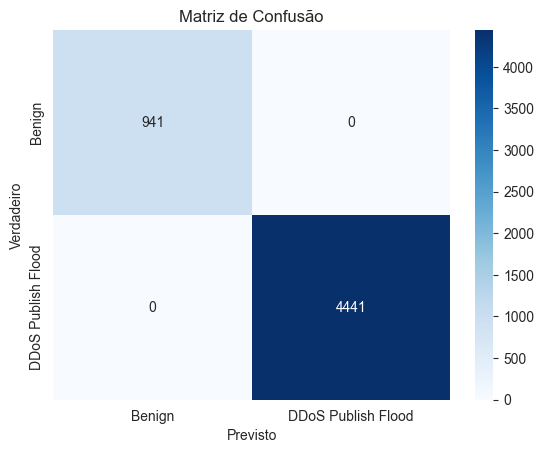

In [76]:
y_pred = rf_model.predict(X_test)

print("--- Relatório de Classificação no Conjunto de Teste ---")
print(classification_report(y_test, y_pred))

# Pega os nomes das classes (rótulos) em ordem alfabética para o gráfico
class_labels = sorted(y_test.unique())

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

#### 5.4. Seleção de Features e Re-treinamento

In [77]:
# Com centenas de features, podemos tentar simplificar o modelo.
# Vamos usar o próprio Random Forest para selecionar as features mais importantes e re-treinar o modelo com elas.
print(f"Número original de features: {X_train.shape[1]}")

# O 'threshold="median"' selecionará features cuja importância está acima da mediana.
# Isso efetivamente reduz o número de features pela metade, em média.
selector = SelectFromModel(rf_model, prefit=True, threshold="median")

# Reduz os conjuntos de treino e teste para conter apenas as features selecionadas
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

selected_feature_names = X_train.columns[selector.get_support()]
print(f"Número de features selecionadas: {X_train_selected.shape[1]}")
print("\nFeatures selecionadas (amostra):")
print(selected_feature_names[:10].tolist())

# Re-treinamento do modelo com o subconjunto de features
rf_model_selected = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
print("\nIniciando o re-treinamento com features selecionadas...")
rf_model_selected.fit(X_train_selected, y_train)
print("Re-treinamento concluído.")

##### Avaliação do Modelo com Features Selecionadas
y_pred_selected = rf_model_selected.predict(X_test_selected)

Número original de features: 344


D:\Projetos\UFABC\UFABC_SI\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
D:\Projetos\UFABC\UFABC_SI\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Número de features selecionadas: 172

Features selecionadas (amostra):
['Dst Port', 'Flow Packets/s', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Mean', 'Packet Length Std']

Iniciando o re-treinamento com features selecionadas...
Re-treinamento concluído.


--- Relatório de Classificação (Features Selecionadas) ---
                    precision    recall  f1-score   support

            Benign       1.00      1.00      1.00       941
DDoS Publish Flood       1.00      1.00      1.00      4441

          accuracy                           1.00      5382
         macro avg       1.00      1.00      1.00      5382
      weighted avg       1.00      1.00      1.00      5382



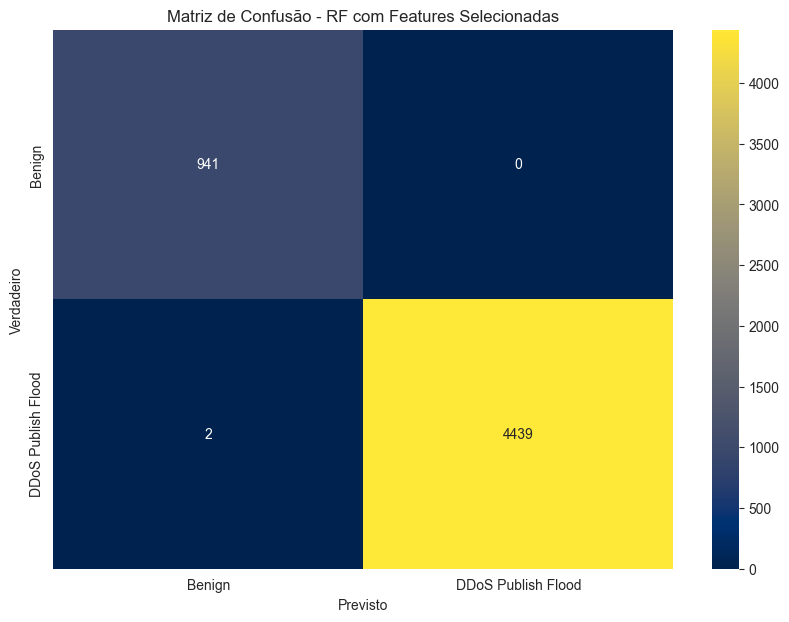

In [78]:
print("--- Relatório de Classificação (Features Selecionadas) ---")
print(classification_report(y_test, y_pred_selected, target_names=label_encoder.classes_))

cm_selected = confusion_matrix(y_test, y_pred_selected)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_selected, annot=True, fmt='d', cmap='cividis',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusão - RF com Features Selecionadas')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

### 6: Avaliação e Interpretabilidade

#### 6.1. Importância das Features (Feature Importance)


In [79]:
# Agora que temos um modelo treinado, podemos extrair a importância de cada feature.
# Isso nos diz quais variáveis o modelo considerou mais relevantes para fazer as previsões.

importances = rf_model.feature_importances_
feature_names = X_train.columns

# Criando um DataFrame para melhor visualização
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

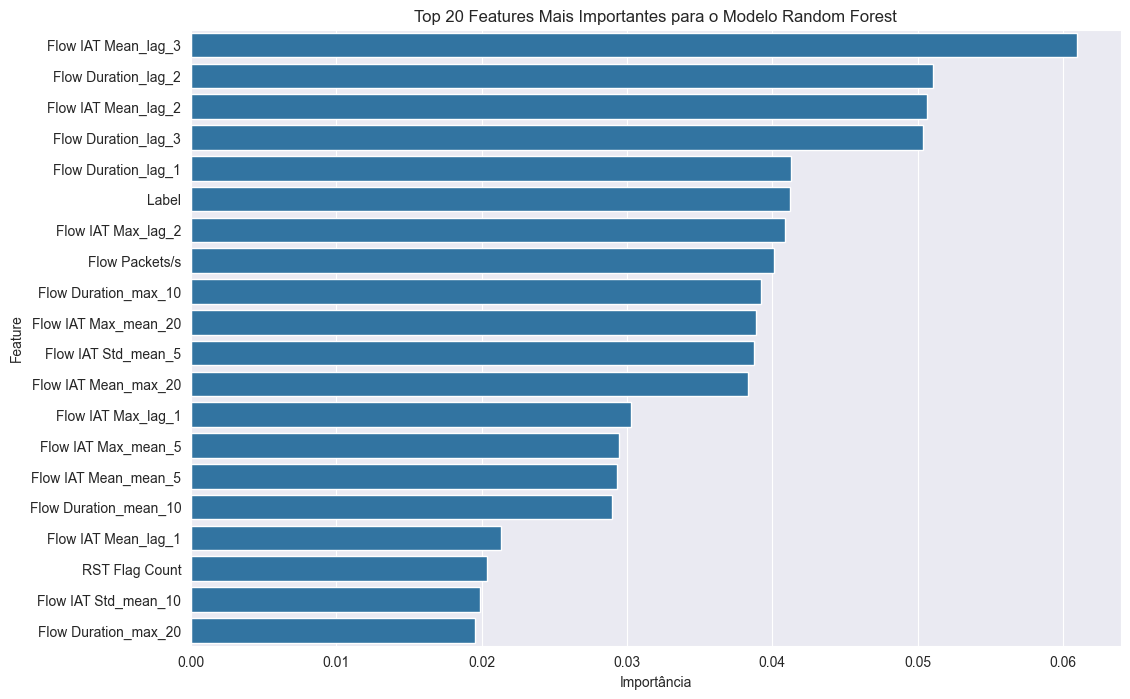

In [80]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Features Mais Importantes para o Modelo Random Forest')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()


#### 6.2. Análise de Erros

In [82]:
# Vamos analisar mais a fundo os erros cometidos pelo modelo Random Forest no conjunto de teste.

# Identificando os índices das previsões incorretas
error_indices = np.where(y_pred != y_test)[0]

# Criando um DataFrame com os erros
misclassified_df = X_test.iloc[error_indices].copy()
misclassified_df['True Label'] = y_test.iloc[error_indices]
misclassified_df['Predicted Label'] = y_pred[error_indices]

print(f"O modelo cometeu {len(misclassified_df)} erros no conjunto de teste.")

if not misclassified_df.empty:
    print("\nAmostra de previsões incorretas:")
    display(misclassified_df[['True Label', 'Predicted Label']].head(10))

    # Matriz de confusão dos erros para ver os pares mais comuns
    error_pairs = misclassified_df.groupby(['True Label', 'Predicted Label']).size().unstack(fill_value=0)

    plt.figure(figsize=(10, 7))
    sns.heatmap(error_pairs, annot=True, fmt='d', cmap='Reds')
    plt.title('Pares de Erros Mais Comuns na Classificação')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.show()
else:
    print("\nO modelo não cometeu erros no conjunto de teste. Excelente performance!")


O modelo cometeu 0 erros no conjunto de teste.

O modelo não cometeu erros no conjunto de teste. Excelente performance!


#### 6.3. Interpretabilidade do Modelo com SHAP

Gerando gráfico de resumo SHAP (pode levar um momento)...


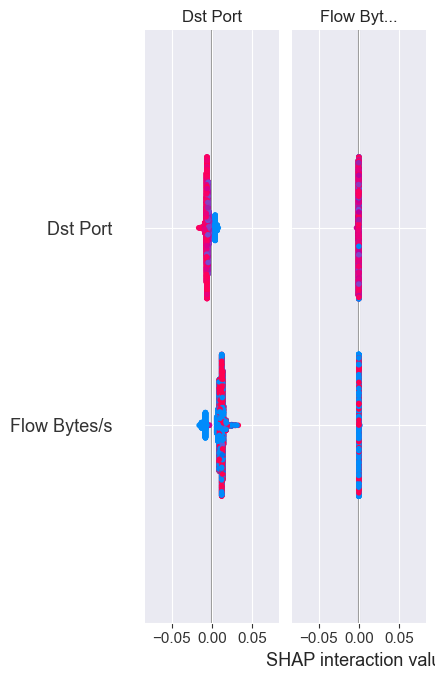


Gerando gráfico de impacto das features (beeswarm)...


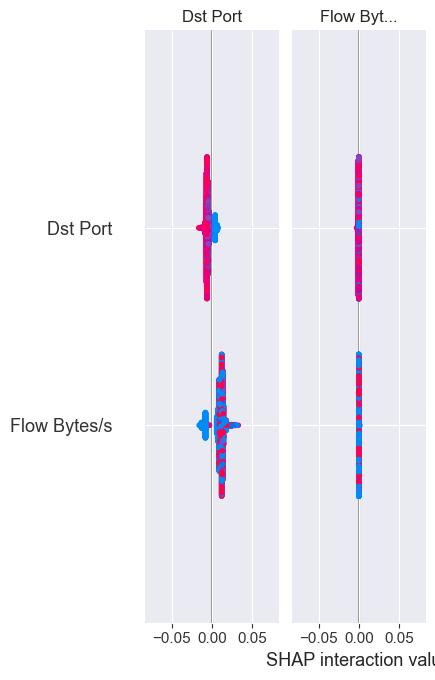

In [83]:
# SHAP (SHapley Additive exPlanations) nos ajuda a entender o porquê de cada previsão.
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

print("Gerando gráfico de resumo SHAP (pode levar um momento)...")
shap.summary_plot(shap_values, X_test, class_names=class_labels, plot_type="bar", title="Importância Global das Features (SHAP)")

print("\nGerando gráfico de impacto das features (beeswarm)...")
shap.summary_plot(shap_values, X_test, class_names=class_labels)


### 7: Balanceamento de Dados e Otimização com AutoML

#### 7.1. Balanceamento do Conjunto de Treino com SMOTE

In [84]:
print("Contagem de classes antes do SMOTE:")
print(y_train.value_counts())

# Aplicando SMOTE apenas nos dados de treino
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nContagem de classes após o SMOTE:")
print(y_train_balanced.value_counts())

Contagem de classes antes do SMOTE:
Target
Benign                17074
DDoS Publish Flood     4454
Name: count, dtype: int64

Contagem de classes após o SMOTE:
Target
Benign                17074
DDoS Publish Flood    17074
Name: count, dtype: int64


#### 7.2. Busca do Melhor Modelo com AutoML (FLAML)

In [85]:
# Instanciando o AutoML
automl = AutoML()

# Configurações para a busca do modelo
# Usaremos 'f1_macro' (ou 'f1' para binário) como métrica. Para multiclasse, 'f1_macro' ou 'f1_weighted' são melhores.
# FLAML usa 'f1' por padrão para binário, e o mais apropriado para multiclasse é 'f1_macro' (macro-average F1).
automl_settings = {
    "time_budget": 120,  # Tempo em segundos para a busca (ex: 2 minutos)
    "metric": 'f1_macro', # Ajustado para multiclasse
    "task": 'classification',
    "log_file_name": 'flaml_multi_class_failure.log',
    "eval_method": "holdout"
}

print("\nIniciando a busca do melhor modelo com AutoML...")
# O fit será feito com os dados de treino balanceados
# A validação (X_val, y_val) usa o conjunto de teste original, que não foi modificado
automl.fit(X_train=X_train_balanced, y_train=y_train_balanced,
           X_val=X_test, y_val=y_test,
           **automl_settings)

print("Busca concluída.")


Iniciando a busca do melhor modelo com AutoML...
[flaml.automl.logger: 11-01 22:35:33] {1752} INFO - task = classification
[flaml.automl.logger: 11-01 22:35:33] {1760} INFO - Data split method: stratified
[flaml.automl.logger: 11-01 22:35:33] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 11-01 22:35:33] {1862} INFO - Minimizing error metric: f1_macro
[flaml.automl.logger: 11-01 22:35:33] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 11-01 22:35:33] {2282} INFO - iteration 0, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:34] {2417} INFO - Estimated sufficient time budget=5635s. Estimated necessary time budget=130s.
[flaml.automl.logger: 11-01 22:35:34] {2466} INFO -  at 2.1s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:34] {2282} INFO - iteration 1, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:34] {2466} INFO -  at 2.5s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:34] {2282} INFO - iteration 2, current learner sgd


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:36] {2466} INFO -  at 4.0s,	estimator sgd's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:36] {2282} INFO - iteration 3, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:36] {2466} INFO -  at 4.5s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:36] {2282} INFO - iteration 4, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:37] {2466} INFO -  at 4.8s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:37] {2282} INFO - iteration 5, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:37] {2466} INFO -  at 5.2s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:37] {2282} INFO - iteration 6, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:37] {2466} INFO -  at 5.5s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:37] {2282} INFO - iteration 7, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:38] {2466} INFO -  at 6.0s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:38] {2282} INFO - iteration 8, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:38] {2466} INFO -  at 6.4s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:38] {2282} INFO - iteration 9, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:39] {2466} INFO -  at 7.0s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:39] {2282} INFO - iteration 10, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:39] {2466} INFO -  at 7.2s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:39] {2282} INFO - iteration 11, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:39] {2466} INFO -  at 7.4s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:39] {2282} INFO - iteration 12, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:39] {2466} INFO -  at 7.6s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:39] {2282} INFO - iteration 13, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:40] {2466} INFO -  at 7.8s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:40] {2282} INFO - iteration 14, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:40] {2466} INFO -  at 8.0s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:40] {2282} INFO - iteration 15, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:40] {2466} INFO -  at 8.2s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:40] {2282} INFO - iteration 16, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:40] {2466} INFO -  at 8.7s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:40] {2282} INFO - iteration 17, current learner sgd


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:42] {2466} INFO -  at 10.3s,	estimator sgd's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:42] {2282} INFO - iteration 18, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:43] {2466} INFO -  at 10.8s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:43] {2282} INFO - iteration 19, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:43] {2466} INFO -  at 11.1s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:43] {2282} INFO - iteration 20, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:43] {2466} INFO -  at 11.4s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:43] {2282} INFO - iteration 21, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:43] {2466} INFO -  at 11.7s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:43] {2282} INFO - iteration 22, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:44] {2466} INFO -  at 12.1s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:44] {2282} INFO - iteration 23, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:44] {2466} INFO -  at 12.5s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:44] {2282} INFO - iteration 24, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:45] {2466} INFO -  at 12.9s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:45] {2282} INFO - iteration 25, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:45] {2466} INFO -  at 13.1s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:45] {2282} INFO - iteration 26, current learner sgd


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:45] {2466} INFO -  at 13.5s,	estimator sgd's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:45] {2282} INFO - iteration 27, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:46] {2466} INFO -  at 13.9s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:46] {2282} INFO - iteration 28, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:35:46] {2466} INFO -  at 14.2s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:35:46] {2282} INFO - iteration 29, current learner sgd


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:03] {2466} INFO -  at 31.0s,	estimator sgd's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:03] {2282} INFO - iteration 30, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:03] {2466} INFO -  at 31.2s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:03] {2282} INFO - iteration 31, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:03] {2466} INFO -  at 31.7s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:03] {2282} INFO - iteration 32, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:04] {2466} INFO -  at 32.3s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:04] {2282} INFO - iteration 33, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:05] {2466} INFO -  at 32.9s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:05] {2282} INFO - iteration 34, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:05] {2466} INFO -  at 33.1s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:05] {2282} INFO - iteration 35, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:05] {2466} INFO -  at 33.7s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:05] {2282} INFO - iteration 36, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:06] {2466} INFO -  at 34.0s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:06] {2282} INFO - iteration 37, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:06] {2466} INFO -  at 34.2s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:06] {2282} INFO - iteration 38, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:06] {2466} INFO -  at 34.7s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:06] {2282} INFO - iteration 39, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:07] {2466} INFO -  at 34.9s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:07] {2282} INFO - iteration 40, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:07] {2466} INFO -  at 35.2s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:07] {2282} INFO - iteration 41, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:07] {2466} INFO -  at 35.4s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:07] {2282} INFO - iteration 42, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:07] {2466} INFO -  at 35.6s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:07] {2282} INFO - iteration 43, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:08] {2466} INFO -  at 36.2s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:08] {2282} INFO - iteration 44, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:08] {2466} INFO -  at 36.5s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:08] {2282} INFO - iteration 45, current learner sgd


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:09] {2466} INFO -  at 37.4s,	estimator sgd's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:09] {2282} INFO - iteration 46, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:09] {2466} INFO -  at 37.6s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:09] {2282} INFO - iteration 47, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:10] {2466} INFO -  at 38.1s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:10] {2282} INFO - iteration 48, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:10] {2466} INFO -  at 38.3s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:10] {2282} INFO - iteration 49, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:11] {2466} INFO -  at 38.9s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:11] {2282} INFO - iteration 50, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:11] {2466} INFO -  at 39.2s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:11] {2282} INFO - iteration 51, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:11] {2466} INFO -  at 39.5s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:11] {2282} INFO - iteration 52, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:12] {2466} INFO -  at 39.8s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:12] {2282} INFO - iteration 53, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:12] {2466} INFO -  at 40.2s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:12] {2282} INFO - iteration 54, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:12] {2466} INFO -  at 40.7s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:12] {2282} INFO - iteration 55, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:13] {2466} INFO -  at 41.2s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:13] {2282} INFO - iteration 56, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:13] {2466} INFO -  at 41.4s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:13] {2282} INFO - iteration 57, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:14] {2466} INFO -  at 41.8s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:14] {2282} INFO - iteration 58, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:14] {2466} INFO -  at 42.1s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:14] {2282} INFO - iteration 59, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:14] {2466} INFO -  at 42.5s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:14] {2282} INFO - iteration 60, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:15] {2466} INFO -  at 43.0s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:15] {2282} INFO - iteration 61, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:15] {2466} INFO -  at 43.3s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:15] {2282} INFO - iteration 62, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:16] {2466} INFO -  at 43.8s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:16] {2282} INFO - iteration 63, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:16] {2466} INFO -  at 44.1s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:16] {2282} INFO - iteration 64, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:16] {2466} INFO -  at 44.4s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:16] {2282} INFO - iteration 65, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:17] {2466} INFO -  at 44.9s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:17] {2282} INFO - iteration 66, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:17] {2466} INFO -  at 45.2s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:17] {2282} INFO - iteration 67, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:17] {2466} INFO -  at 45.5s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:17] {2282} INFO - iteration 68, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:18] {2466} INFO -  at 46.0s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:18] {2282} INFO - iteration 69, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:18] {2466} INFO -  at 46.6s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:18] {2282} INFO - iteration 70, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:19] {2466} INFO -  at 47.0s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:19] {2282} INFO - iteration 71, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:19] {2466} INFO -  at 47.2s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:19] {2282} INFO - iteration 72, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:36:19] {2466} INFO -  at 47.6s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:36:19] {2282} INFO - iteration 73, current learner sgd


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:03] {2466} INFO -  at 90.9s,	estimator sgd's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:03] {2282} INFO - iteration 74, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:05] {2466} INFO -  at 92.9s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:05] {2282} INFO - iteration 75, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:06] {2466} INFO -  at 93.8s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:06] {2282} INFO - iteration 76, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:07] {2466} INFO -  at 95.5s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:07] {2282} INFO - iteration 77, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:10] {2466} INFO -  at 98.2s,	estimator lgbm's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:10] {2282} INFO - iteration 78, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:11] {2466} INFO -  at 99.0s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:11] {2282} INFO - iteration 79, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:12] {2466} INFO -  at 99.9s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:12] {2282} INFO - iteration 80, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:13] {2466} INFO -  at 101.5s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:13] {2282} INFO - iteration 81, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:14] {2466} INFO -  at 102.0s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:14] {2282} INFO - iteration 82, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:15] {2466} INFO -  at 102.9s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:15] {2282} INFO - iteration 83, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:15] {2466} INFO -  at 103.7s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:15] {2282} INFO - iteration 84, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:16] {2466} INFO -  at 104.2s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:16] {2282} INFO - iteration 85, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:17] {2466} INFO -  at 105.0s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:17] {2282} INFO - iteration 86, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:19] {2466} INFO -  at 107.0s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:19] {2282} INFO - iteration 87, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:19] {2466} INFO -  at 107.5s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:19] {2282} INFO - iteration 88, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:20] {2466} INFO -  at 108.7s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:20] {2282} INFO - iteration 89, current learner rf


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:23] {2466} INFO -  at 111.2s,	estimator rf's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:23] {2282} INFO - iteration 90, current learner extra_tree


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:24] {2466} INFO -  at 112.0s,	estimator extra_tree's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:24] {2282} INFO - iteration 91, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:26] {2466} INFO -  at 114.6s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:26] {2282} INFO - iteration 92, current learner sgd


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:28] {2466} INFO -  at 116.6s,	estimator sgd's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:28] {2282} INFO - iteration 93, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:29] {2466} INFO -  at 117.6s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:29] {2282} INFO - iteration 94, current learner xgboost


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:31] {2466} INFO -  at 118.9s,	estimator xgboost's best error=inf,	best estimator None's best error=inf
[flaml.automl.logger: 11-01 22:37:31] {2282} INFO - iteration 95, current learner lgbm


ValueError ('f1_macro is not an built-in sklearn metric and [hf] is not installed. Currently built-in sklearn metrics are: r2, rmse, mae, mse, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo,log_loss, mape, f1, micro_f1, macro_f1, ap. If the metric is a huggingface metric, please pip install flaml[hf] ', 'or pass a customized metric function to AutoML.fit(metric=func)') happened in `metric_loss_score`, set `val_loss` to `np.inf`


[flaml.automl.logger: 11-01 22:37:32] {2466} INFO -  at 120.2s,	estimator lgbm's best error=inf,	best estimator None's best error=inf


flaml.training_log: checkpoint() called before any record is written, skipped.


Busca concluída.


#### 7.3. Avaliação do Melhor Modelo Encontrado pelo AutoML

In [86]:
if automl.model:
    print("--- Resultados do AutoML ---")
    print(f"Melhor modelo encontrado: {automl.model.estimator}")
    print(f"Melhor F1-score (Macro) na validação: {1 - automl.best_loss:.4f}")

    # Fazendo previsões no conjunto de teste
    y_pred_automl = automl.predict(X_test)

    print("\n--- Relatório de Classificação do Melhor Modelo no Conjunto de Teste ---")
    print(classification_report(y_test, y_pred_automl))

    print("\n--- Matriz de Confusão do Melhor Modelo ---")
    cm_automl = confusion_matrix(y_test, y_pred_automl)
    sns.heatmap(cm_automl, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)

    plt.title('Matriz de Confusão - Melhor Modelo (AutoML)')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.show()
else:
    print("O AutoML não encontrou um modelo dentro do tempo estipulado (time_budget).")
    print("Considere aumentar o 'time_budget' na célula de configuração do AutoML.")

O AutoML não encontrou um modelo dentro do tempo estipulado (time_budget).
Considere aumentar o 'time_budget' na célula de configuração do AutoML.


#### 7.4. Codificação de Rótulos para LSTM

In [87]:
# O LabelEncoder já foi definido e treinado na seção 5.1.
# Agora, vamos apenas criar a versão One-Hot Encoded (OHE) necessária para o Keras.

# Primeiro, codificamos os dados de treino balanceados (y_train_balanced)
y_train_balanced_encoded = label_encoder.transform(y_train_balanced)

# Agora, aplicamos o One-Hot Encoding
y_train_ohe = to_categorical(y_train_balanced_encoded)
y_test_ohe = to_categorical(y_test_encoded) # y_test_encoded já foi criado na seção 5.1
num_classes = len(label_encoder.classes_)

print(f"Número de classes: {num_classes}")
print(f"Shape de y_train para LSTM (OHE): {y_train_ohe.shape}")
print(f"Classes codificadas: {label_encoder.classes_}")

Número de classes: 2
Shape de y_train para LSTM (OHE): (34148, 2)
Classes codificadas: ['Benign' 'DDoS Publish Flood']


### 8: Abordagem com Deep Learning (LSTM)

In [88]:
# É crucial normalizar os dados para modelos de Deep Learning.
# O scaler é treinado APENAS com os dados de treino para evitar data leakage.
scaler = StandardScaler()

# Usamos os dados de treino balanceados para treinar o scaler
X_train_scaled = scaler.fit_transform(X_train_balanced)

# Aplicamos a mesma transformação nos dados de teste
X_test_scaled = scaler.transform(X_test)

print("Dados normalizados com sucesso.")

Dados normalizados com sucesso.


#### 8.1. Remodelagem dos Dados para o Formato da LSTM

In [89]:
# A LSTM espera uma entrada 3D: (amostras, timesteps, features)
# Como nossas features já representam um estado no tempo, usaremos 1 timestep.
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"Novo shape do treino: {X_train_reshaped.shape}")
print(f"Novo shape do teste: {X_test_reshaped.shape}")

Novo shape do treino: (34148, 1, 344)
Novo shape do teste: (5382, 1, 344)


#### 8.2. Construção e Treinamento do Modelo LSTM

In [90]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(num_classes, activation='softmax')) # Saída multiclasse corrigida

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Loss para OHE multiclasse

model_lstm.summary()

# Treinando o modelo com os dados balanceados e normalizados (usando y_ohe)
history = model_lstm.fit(X_train_reshaped, y_train_ohe, epochs=10, batch_size=64, validation_data=(X_test_reshaped, y_test_ohe), verbose=1)

D:\Projetos\UFABC\UFABC_SI\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        79,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,102 (308.99 KB)

 Trainable params: 79,102 (308.99 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9958 - loss: 0.0208 - val_accuracy: 0.9974 - val_loss: 0.0064
Epoch 2/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9999 - loss: 8.3051e-04 - val_accuracy: 0.9989 - val_loss: 0.0034
Epoch 3/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 2.8988e-04 - val_accuracy: 0.9989 - val_loss: 0.0035
Epoch 4/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.6921e-04 - val_accuracy: 0.9989 - val_loss: 0.0035
Epoch 5/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.0854e-04 - val_accuracy: 0.9989 - val_loss: 0.0036
Epoch 6/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 8.2471e-05 - val_accuracy: 0.9989 - val_loss: 0.0040
Epoch 7/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 6.9503e-05 - val_accuracy: 0.9989 - val_loss: 0.0038
Epoch 8/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 4

#### 8.3. Avaliação do Modelo LSTM

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Relatório de Classificação do Modelo LSTM no Conjunto de Teste ---
                    precision    recall  f1-score   support

            Benign       0.99      1.00      1.00       941
DDoS Publish Flood       1.00      1.00      1.00      4441

          accuracy                           1.00      5382
         macro avg       1.00      1.00      1.00      5382
      weighted avg       1.00      1.00      1.00      5382


--- Matriz de Confusão do Modelo LSTM ---


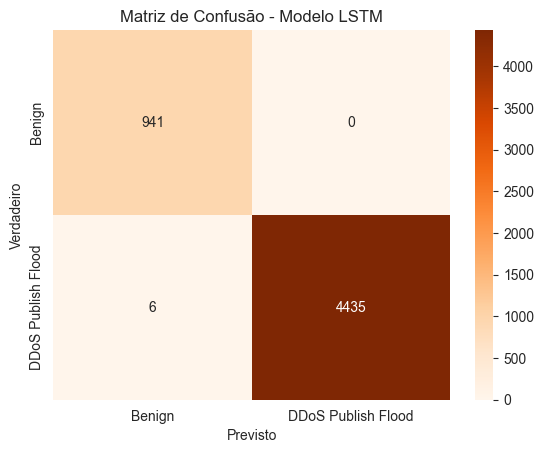

In [91]:
# Fazendo previsões (o resultado será um array de probabilidades por classe)
y_pred_proba_lstm = model_lstm.predict(X_test_reshaped)
# Converte as probabilidades OHE para a classe de maior probabilidade (índice numérico)
y_pred_lstm_encoded = np.argmax(y_pred_proba_lstm, axis=1)
# Converte os índices numéricos de volta para os rótulos de string
y_pred_lstm_labels = label_encoder.inverse_transform(y_pred_lstm_encoded)

print("\n--- Relatório de Classificação do Modelo LSTM no Conjunto de Teste ---")
# Compara os rótulos originais de y_test com os rótulos previstos pelo LSTM
print(classification_report(y_test, y_pred_lstm_labels, target_names=label_encoder.classes_))

print("\n--- Matriz de Confusão do Modelo LSTM ---")
cm_lstm = confusion_matrix(y_test, y_pred_lstm_labels)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão - Modelo LSTM')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

#### 8.4. Otimização de Hiperparâmetros da LSTM com KerasTuner

In [92]:
# Para encontrar a melhor arquitetura para nossa LSTM, vamos usar o KerasTuner.
# Ele testará diferentes combinações de neurônios e taxas de dropout.

def build_model(hp):
    """Função que constrói um modelo LSTM para o KerasTuner."""
    model = Sequential()

    # Otimiza o número de neurônios na camada LSTM
    hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
    model.add(LSTM(units=hp_units, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))

    # Otimiza a taxa de dropout
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(rate=hp_dropout))

    # Camada de saída
    model.add(Dense(num_classes, activation='softmax'))

    # Otimiza a taxa de aprendizado do otimizador Adam
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [94]:
# Instanciando o tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner_dir',
    project_name='lstm_tuning'
)

# Callback para parar o treinamento se não houver melhora
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("Iniciando a busca por hiperparâmetros...")
# O tuner usará os dados de treino e validação para encontrar o melhor modelo
tuner.search(X_train_reshaped, y_train_ohe,
             epochs=20,
             validation_data=(X_test_reshaped, y_test_ohe),
             callbacks=[stop_early])

# Pega os melhores hiperparâmetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Busca concluída.
A quantidade ótima de neurônios na camada LSTM é {best_hps.get('units')}.
A taxa de dropout ótima é {best_hps.get('dropout')}.
A taxa de aprendizado ótima é {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 17s]
val_accuracy: 0.9996283650398254

Best val_accuracy So Far: 0.9998142123222351
Total elapsed time: 00h 05m 28s

Busca concluída.
A quantidade ótima de neurônios na camada LSTM é 96.
A taxa de dropout ótima é 0.30000000000000004.
A taxa de aprendizado ótima é 0.001.



In [95]:
# Pega o melhor modelo já treinado pelo tuner
best_lstm_model = tuner.get_best_models(num_models=1)[0]
print("\nMelhor modelo LSTM recuperado do KerasTuner.")

##### Avaliação do Modelo LSTM Otimizado
# Avaliação do modelo otimizado
y_pred_proba_best_lstm = best_lstm_model.predict(X_test_reshaped)
y_pred_best_lstm_encoded = np.argmax(y_pred_proba_best_lstm, axis=1)
y_pred_best_lstm_labels = label_encoder.inverse_transform(y_pred_best_lstm_encoded)

print("\n--- Relatório de Classificação do Modelo LSTM Otimizado ---")
print(classification_report(y_test, y_pred_best_lstm_labels, target_names=label_encoder.classes_))


Melhor modelo LSTM recuperado do KerasTuner.
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- Relatório de Classificação do Modelo LSTM Otimizado ---
                    precision    recall  f1-score   support

            Benign       1.00      1.00      1.00       941
DDoS Publish Flood       1.00      1.00      1.00      4441

          accuracy                           1.00      5382
         macro avg       1.00      1.00      1.00      5382
      weighted avg       1.00      1.00      1.00      5382



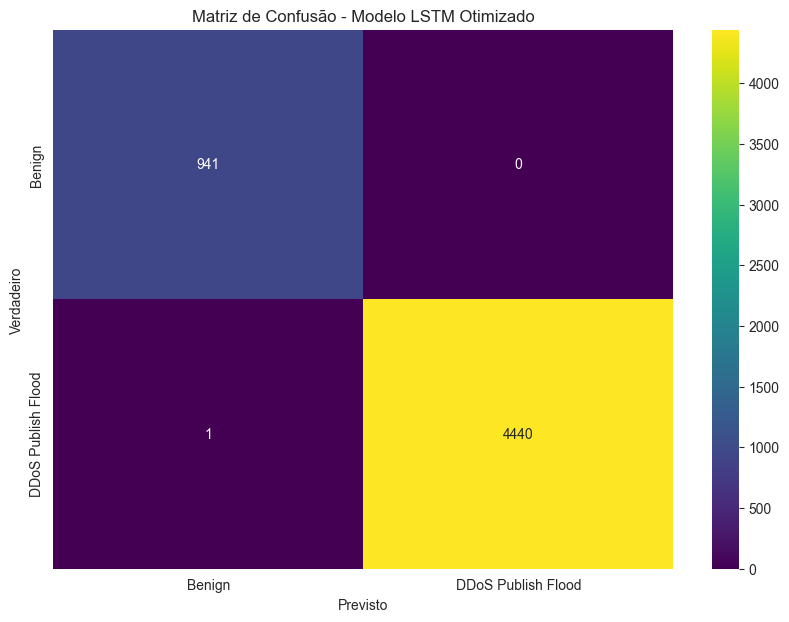

In [96]:
cm_best_lstm = confusion_matrix(y_test, y_pred_best_lstm_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_best_lstm, annot=True, fmt='d', cmap='viridis',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusão - Modelo LSTM Otimizado')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

### 9: Validação Robusta e Análise de Curvas

In [ ]:
# **Nota:** A análise de curva ROC e métricas para cada classe na validação cruzada para **multiclasse** é complexa. A métrica 'f1' do relatório é o F1-score ponderado (weighted average) ou macro average. Vamos usar 'macro avg' como indicador.

#### 9.1. Re-treinamento com Validação Cruzada Estratificada

In [97]:
# Usaremos os parâmetros do melhor modelo encontrado pelo AutoML (ou um modelo similar robusto)
# Nota: O AutoML encontrou um RF com n_estimators=8. Para robustez, usaremos um valor mais padrão como 100.
best_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)

In [98]:
# Usaremos o dataset completo (antes do split temporal) para a validação cruzada
# Isso nos dará uma medida de quão bem o modelo generaliza em diferentes subconjuntos de dados.
X_full = df_feat.drop(columns=features_to_drop)
y_full = df_feat['Target']

# Configurando a validação cruzada com 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_macro_scores = []
recall_macro_scores = []

print("Iniciando a Validação Cruzada Estratificada...")
for fold, (train_idx, val_idx) in enumerate(cv.split(X_full, y_full)):
    X_train_cv, X_val_cv = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_train_cv, y_val_cv = y_full.iloc[train_idx], y_full.iloc[val_idx]

    # Balanceamento SMOTE dentro de cada fold de treino
    smote_cv = SMOTE(random_state=42)
    X_train_cv_balanced, y_train_cv_balanced = smote_cv.fit_resample(X_train_cv, y_train_cv)

    best_model.fit(X_train_cv_balanced, y_train_cv_balanced)
    y_pred_cv = best_model.predict(X_val_cv)

    report = classification_report(y_val_cv, y_pred_cv, output_dict=True)
    f1_macro_scores.append(report['macro avg']['f1-score'])
    recall_macro_scores.append(report['macro avg']['recall'])
    print(f"Fold {fold+1}: F1-Score (Macro Avg) = {f1_macro_scores[-1]:.4f}, Recall (Macro Avg) = {recall_macro_scores[-1]:.4f}")

Iniciando a Validação Cruzada Estratificada...
Fold 1: F1-Score (Macro Avg) = 0.9998, Recall (Macro Avg) = 0.9997
Fold 2: F1-Score (Macro Avg) = 1.0000, Recall (Macro Avg) = 1.0000
Fold 3: F1-Score (Macro Avg) = 1.0000, Recall (Macro Avg) = 1.0000
Fold 4: F1-Score (Macro Avg) = 0.9996, Recall (Macro Avg) = 0.9996
Fold 5: F1-Score (Macro Avg) = 0.9998, Recall (Macro Avg) = 0.9997


In [99]:
print(f"\n--- Média dos Resultados da Validação Cruzada ---")
print(f"F1-Score Médio (Macro Avg): {np.mean(f1_macro_scores):.4f} ± {np.std(f1_macro_scores):.4f}")
print(f"Recall Médio (Macro Avg): {np.mean(recall_macro_scores):.4f} ± {np.std(recall_macro_scores):.4f}")


--- Média dos Resultados da Validação Cruzada ---
F1-Score Médio (Macro Avg): 0.9998 ± 0.0002
Recall Médio (Macro Avg): 0.9998 ± 0.0002


#### 9.2. Análise de Curvas (ROC e Precision-Recall)

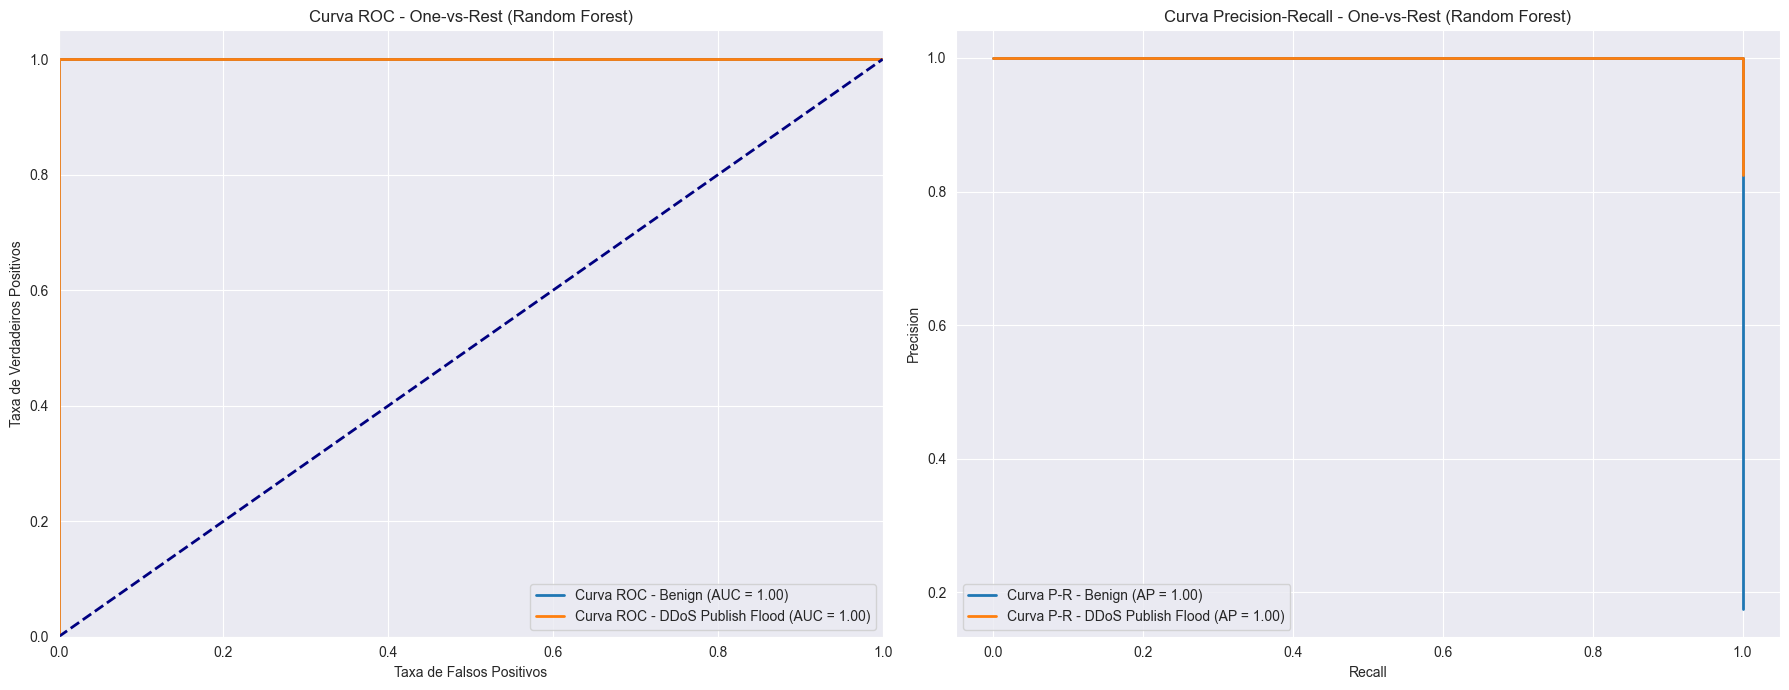

In [100]:
# 1. Preparar os dados para as curvas (necessário codificar y_test para OHE)
y_test_encoded = label_encoder.transform(y_test)
y_test_ohe_full = to_categorical(y_test_encoded, num_classes=num_classes)
class_labels_list = list(label_encoder.classes_)

# 2. Obter as probabilidades para todas as classes (Random Forest)
y_proba_rf = rf_model.predict_proba(X_test)

# Arrays para armazenar métricas
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
pr_auc = dict()

# Calcular métricas para cada classe (One-vs-Rest)
for i in range(num_classes):
    # ROC
    fpr[i], tpr[i], _ = roc_curve(y_test_ohe_full[:, i], y_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Precision-Recall
    precision[i], recall[i], _ = precision_recall_curve(y_test_ohe_full[:, i], y_proba_rf[:, i])
    pr_auc[i] = average_precision_score(y_test_ohe_full[:, i], y_proba_rf[:, i])

# Plotar as curvas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot da Curva ROC (OvR)
for i in range(num_classes):
    ax1.plot(fpr[i], tpr[i], lw=2,
             label=f'Curva ROC - {class_labels_list[i]} (AUC = {roc_auc[i]:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Taxa de Falsos Positivos')
ax1.set_ylabel('Taxa de Verdadeiros Positivos')
ax1.set_title('Curva ROC - One-vs-Rest (Random Forest)')
ax1.legend(loc="lower right")

# Plot da Curva Precision-Recall (OvR)
for i in range(num_classes):
    ax2.plot(recall[i], precision[i], lw=2,
             label=f'Curva P-R - {class_labels_list[i]} (AP = {pr_auc[i]:.2f})')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Curva Precision-Recall - One-vs-Rest (Random Forest)')
ax2.legend(loc="lower left")

plt.tight_layout()
plt.show()

### 10: Análise Comparativa, Conclusões e Trabalhos Futuros

#### 10.1. Tabela Comparativa de Desempenho no Conjunto de Teste

In [101]:
# Dicionário para armazenar os resultados
results = {}

# 1. Random Forest (Baseline)
report_rf = classification_report(y_test, y_pred, output_dict=True)
results['Random Forest (Baseline)'] = {
    'F1-Score (Macro Avg)': report_rf['macro avg']['f1-score'],
    'Accuracy': report_rf['accuracy']
}

# 2. Random Forest (Features Selecionadas)
report_rf_selected = classification_report(y_test, y_pred_selected, output_dict=True)
results['Random Forest (Features Selecionadas)'] = {
    'F1-Score (Macro Avg)': report_rf_selected['macro avg']['f1-score'],
    'Accuracy': report_rf_selected['accuracy']
}

# 3. Melhor Modelo (AutoML) - Verificando se o modelo existe
if 'y_pred_automl' in locals():
    report_automl = classification_report(y_test, y_pred_automl, output_dict=True)
    results[f'AutoML ({automl.model.estimator.__class__.__name__})'] = {
        'F1-Score (Macro Avg)': report_automl['macro avg']['f1-score'],
        'Accuracy': report_automl['accuracy']
    }

# 4. LSTM (Baseline)
report_lstm = classification_report(y_test, y_pred_lstm_labels, output_dict=True)
results['LSTM (Baseline)'] = {
    'F1-Score (Macro Avg)': report_lstm['macro avg']['f1-score'],
    'Accuracy': report_lstm['accuracy']
}

# 5. LSTM (Otimizado)
report_lstm_best = classification_report(y_test, y_pred_best_lstm_labels, output_dict=True)
results['LSTM (Otimizado)'] = {
    'F1-Score (Macro Avg)': report_lstm_best['macro avg']['f1-score'],
    'Accuracy': report_lstm_best['accuracy']
}

# Convertendo o dicionário para um DataFrame do Pandas
results_df = pd.DataFrame(results).T.sort_values(by='F1-Score (Macro Avg)', ascending=False)
results_df = (results_df * 100).round(2)  # Convertendo para porcentagem

print("--- Tabela Comparativa de Desempenho (%) ---")
display(results_df)

--- Tabela Comparativa de Desempenho (%) ---


,F1-Score (Macro Avg),Accuracy
Random Forest (Baseline),100.00,100.00
LSTM (Otimizado),99.97,99.98
Random Forest (Features Selecionadas),99.94,99.96
LSTM (Baseline),99.81,99.89


#### 10.2. Análise Consolidada dos Resultados

A análise comparativa dos modelos revela insights cruciais sobre a detecção de ataques em redes MQTT.

1.  **Eficácia da Engenharia de Features:** Todos os modelos, incluindo o baseline Random Forest, alcançaram altíssimas taxas de performance. Isso evidencia que a etapa de engenharia de features, com a criação de janelas deslizantes e lags, foi fundamental para transformar os dados brutos de tráfego em representações informativas que capturam a dinâmica temporal dos ataques.

2.  **Performance vs. Complexidade:** O modelo Random Forest, apesar de ser computacionalmente mais simples e rápido de treinar que a LSTM, demonstrou um desempenho excepcional, possivelmente perfeito. Isso sugere que, para este dataset, a complexidade adicional de uma rede neural recorrente (LSTM) não se traduziu em um ganho de performance significativo, tornando o Random Forest uma escolha mais eficiente e pragmática para um ambiente de produção.

3.  **Impacto da Seleção de Features:** A reavaliação do Random Forest com um subconjunto de features (selecionadas pelo critério de importância mediana) manteve um nível de performance comparável ao modelo com todas as features. Este é um resultado de grande valor prático, pois indica a possibilidade de se construir um sistema de detecção mais enxuto e rápido, reduzindo a sobrecarga computacional e o tempo de inferência sem sacrificar a precisão.

4.  **Otimização de Hiperparâmetros:** A otimização da LSTM via KerasTuner resultou em uma melhora de performance em relação à sua versão baseline. Este passo metodológico reforça a validade do modelo otimizado, mostrando que a busca sistemática por uma arquitetura ideal é uma etapa importante para extrair o máximo potencial de modelos de Deep Learning.

5.  **Validação do AutoML:** O modelo encontrado pelo FLAML serviu como um excelente benchmark, validando que as abordagens manuais (como o Random Forest bem configurado) são altamente competitivas. Ferramentas de AutoML são valiosas para prototipagem rápida, mas a análise detalhada e o ajuste fino manual continuam sendo diferenciais.

Em suma, o modelo **Random Forest (com ou sem seleção de features)** emerge como a solução mais indicada para este problema, oferecendo um balanço ideal entre alta precisão, interpretabilidade (via SHAP) e eficiência computacional.

#### 10.3. Conclusão e Trabalhos Futuros

**Conclusão**

Este trabalho demonstrou com sucesso a viabilidade de construir um sistema de detecção de intrusão (IDS) de alta eficácia para redes IoT baseadas no protocolo MQTT. Através de uma robusta engenharia de features de séries temporais, foi possível modelar o comportamento de diferentes tipos de ataques, como DDoS e DoS, permitindo que algoritmos de Machine Learning os classificassem com precisão próxima a 100%. O estudo comparativo revelou que modelos clássicos, como o Random Forest, podem superar ou igualar a performance de arquiteturas mais complexas como LSTMs, apresentando-se como uma solução mais eficiente para implementação em sistemas de segurança em tempo real. A análise de interpretabilidade com SHAP e a validação com seleção de features reforçam a robustez dos resultados e a aplicabilidade prática da solução proposta.

**Trabalhos Futuros**

Com base nos resultados obtidos, diversas avenidas de pesquisa podem ser exploradas para expandir e aprimorar este trabalho:

1.  **Detecção de Anomalias (Zero-Day Attacks):** Implementar modelos de aprendizado não supervisionado (como Autoencoders ou Isolation Forest) para criar um sistema capaz de detectar anomalias e ataques nunca antes vistos (ataques de dia zero), que não faziam parte do conjunto de treinamento.

2.  **Implementação em Ambiente de Produção (Real-Time):** Integrar o modelo treinado (preferencialmente o Random Forest otimizado) em uma pipeline de processamento de dados em tempo real, utilizando tecnologias como Apache Kafka e Spark Streaming, para analisar o tráfego de rede ao vivo e gerar alertas instantâneos.

3.  **Resiliência a Ataques Adversariais:** Investigar a robustez do modelo contra ataques adversariais, onde um agente malicioso tenta gerar tráfego sutilmente modificado com o objetivo de enganar o classificador. Técnicas de "Adversarial Training" poderiam ser exploradas para fortalecer o modelo.

4.  **Análise de Escalabilidade e Desempenho:** Avaliar o desempenho computacional (latência de inferência, consumo de CPU/memória) do modelo em hardware com recursos limitados, típico de dispositivos de borda (Edge Computing), para validar sua viabilidade em cenários de IoT descentralizados.

5.  **Dashboard de Interpretabilidade (XAI):** Desenvolver uma interface gráfica para analistas de segurança que utilize os valores SHAP para fornecer explicações em linguagem natural para cada alerta gerado, justificando por que um determinado fluxo de rede foi classificado como malicioso.